# Memoria del Proyecto: Análisis de datos de tráfico en Madrid

## 1. Introducción

## 2. Descripción de los Datos

## 3. Metodología y Herramientas

## 4. Análisis Exploratorio Obligatorio

### 4.1 Estadísticas Básicas

### 4.2 Series Temporales para un Sensor

## 5. Análisis Avanzado: Agrupación por Distritos

### 5.1 Análisis del Distrito Céntrico

### 5.2 Mapa de Sensores y Tráfico

### 5.3 Intento de Heatmap

## 6. Discusión y Conclusiones

## 7. Referencias


## 1. Introducción
El objetivo de este proyecto es analizar el tráfico en la ciudad de Madrid utilizando datos abiertos obtenidos mediante la API del Ayuntamiento. A través de este estudio, se busca comprender los patrones de circulación y su variación en diferentes áreas y periodos, contribuyendo a la gestión inteligente de la movilidad urbana.

### Descargar los datos via API

In [ ]:
import requests

# paste url of data
url = 'https://datos.madrid.es/egob/catalogo/208627-148-transporte-ptomedida-historico.zip'

response = requests.get(url)
if response.status_code == 200:
    with open('septiembre.zip', 'wb') as f:
        f.write(response.content)
    print("Download complete!")
else:
    print("Download failed. Status code:", response.status_code)


Download complete!


In [4]:
import os
# Unzip the downloaded file
# importing the zipfile module
from zipfile import ZipFile

# loading the septiembre.zip and creating a zip object
with ZipFile("septiembre.zip", 'r') as zObject:

    # Extracting all the members of the zip 
    # into a specific location.
    # check if the file already exists to avoid overwriting
    if os.path.exists("/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/"):
        print("Data folder already exists. Skipping extraction.")
    else:
        zObject.extractall(path="/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/")
    
# delete the zip file after extraction
import os
os.remove("septiembre.zip")


Data folder already exists. Skipping extraction.


### Datos

In [3]:
# load data into pandas dataframe
import pandas as pd
import numpy as np

data = pd.read_csv('/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/09-2025.csv', sep=';')

# explore data
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13082675 entries, 0 to 13082674
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   fecha                object 
 2   tipo_elem            object 
 3   intensidad           int64  
 4   ocupacion            int64  
 5   carga                int64  
 6   vmed                 float64
 7   error                object 
 8   periodo_integracion  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 898.3+ MB


,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1006,2025-09-01 00:00:00,C30,660,2,0,60.0,N,5
1,1006,2025-09-01 00:15:00,C30,324,1,0,60.0,N,5
2,1006,2025-09-01 00:30:00,C30,228,0,0,63.0,N,5
3,1006,2025-09-01 00:45:00,C30,96,0,0,61.0,N,5
4,1006,2025-09-01 01:00:00,C30,264,1,0,61.0,N,5


In [4]:
## transform and clean up dataframe 
# convert column fecha to datetime
data["fecha"] = pd.to_datetime(data["fecha"])
data = data.set_index("fecha")

# check for errors and remove them
print("Number of non optimal or errouneous observations:", len(data[data["error"] != "N"]))
data = data[data["error"] == "N"] # keep only good observations

# create column with total number of cars per 15 minute period
data["coches_total"] = data["intensidad"] / 4



Number of non optimal or errouneous observations: 76336


#### Descripción de los datos
Para el análisis se han descargado los archivos de datos de tráfico directamente desde la API oficial del Ayuntamiento de Madrid. Los datos se presentan en formato CSV e incluyen variables como id de sensor, fecha y hora, intensidad de tráfico y velocidad media. Antes de la limpieza y el análisis, se eliminaron las entregas erróneas para asegurar la calidad de las estadísticas calculadas.

## 2. Análisis de datos

El procesamiento y análisis de datos se realizaron principalmente con pandas para la manipulación e integración de datos y con matplotlib para la generación de gráficos. Se desarrollaron funciones personalizadas para obtener las estadísticas relevantes necesarias. El proceso se realizó de manera que permite usar las funciones con diferentes datos, sensores de tráfico y periodos de agregación, de modo que se pueden reutilizar las funciones si se quieren analizar otros periodos de tiempo.

### Estadisticas por todos los sensores

In [ ]:
def get_relevant_sensors(data, sensor_type, aggregation_period = None):
    """Create statitsics for all sensors and save relevant sensor ids in dictionary for further plotting"""
    
    if sensor_type in ["M30", "C30"]:
        print(f"\n Relevant statistic for sensor type M30 with aggregation period: {aggregation_period}")
        data_filtered = data[(data["tipo_elem"] == "C30") | (data["tipo_elem"] == "M30")]
    elif sensor_type == "URB":
        print(f"\n Relevant statistic for sensor type URB with aggregation period: {aggregation_period}")
        data_filtered = data[data["tipo_elem"] == "URB"]
    else:
        return None
    
    # Resampling but only for numeric columsn
    if aggregation_period is not None:
        # get numeric columns
        numeric_cols = ["intensidad", "vmed", "ocupacion", "carga", "coches_total"]
        # keep id column to group by
        data_filtered = data_filtered.groupby("id")[numeric_cols].resample(aggregation_period).mean().reset_index(level=0)

    # aggregate data by sensor id
    data_agg = data_filtered.groupby("id").agg({
        "intensidad": ["min", "max", "mean", "median"], 
        "vmed": ["min", "max", "mean", "median"]
    })
    
    # calculate mode 
    def safe_mode(series):
        mode_result = series.mode()
        return mode_result.iloc[0] if len(mode_result) > 0 else series.median()
    
    intensity_modes = data_filtered.groupby("id")["intensidad"].apply(safe_mode)
    
    # collect relevant sensors in dictionary
    relevant_sensors = {
        'min_intensity': data_agg["intensidad"]["min"].idxmin(),
        'max_intensity': data_agg["intensidad"]["max"].idxmax(),
        'mean_intensity': abs(data_agg["intensidad"]["mean"] - data_agg["intensidad"]["mean"].mean()).idxmin(),
        'median_intensity': abs(data_agg["intensidad"]["median"] - data_agg["intensidad"]["median"].mean()).idxmin(),
        'mode_intensity': abs(intensity_modes - intensity_modes.mean()).idxmin(),
        'mean_speed': abs(data_agg["vmed"]["mean"] - data_agg["vmed"]["mean"].mean()).idxmin()
    }

    ## print statistics
    # print sensor with minimum and maximum intensity
    print(f"Sensor id with minimum intensity {relevant_sensors['min_intensity']}")
    print(f"Sensor id with maximum intensity {relevant_sensors['max_intensity']}")

    # print sensors closest to mean and median value
    for stat in ["mean", "median"]:
        for char in ["intensidad", "vmed"]:
            overall_stat = data_agg[char][stat].mean()
            if overall_stat != 0:
                closest_sensor = abs(data_agg[char][stat] - overall_stat).idxmin()
                print(f"Sensor id closest to {stat} {char}: {closest_sensor} (value: {overall_stat:.1f})")

    # print sensors closest to mode
    # closest sensor to mode 
    if sensor_type in ["M30", "C30"]:
        speed_modes = data_filtered.groupby("id")["vmed"].apply(safe_mode)
        speed_overall_mode = speed_modes.mean()
        closest_sensor_speed_mode = abs(speed_modes - speed_overall_mode).idxmin()
        print(f"Sensor id closest to mode vmed: {closest_sensor_speed_mode} (value: {speed_overall_mode:.1f})")

    print(f"Sensor id closest to mode intensidad: {relevant_sensors['mode_intensity']} (value: {intensity_modes.mean():.1f})")
    
    return relevant_sensors, data_filtered

# use function to get relevant sensors for M30 and URB
m30_sensors, m30_data = get_relevant_sensors(data, "M30", aggregation_period = None)
urb_sensors, urb_data = get_relevant_sensors(data, "URB", aggregation_period = None)



 Relevant statistic for sensor type M30 with aggregation period: None
Sensor id with minimum intensity 1006
Sensor id with maximum intensity 6842
Sensor id closest to mean intensidad: 3495 (value: 1164.5)
Sensor id closest to mean vmed: 6640 (value: 60.6)
Sensor id closest to median intensidad: 6771 (value: 1297.8)
Sensor id closest to median vmed: 3542 (value: 64.2)
Sensor id closest to mode vmed: 3532 (value: 64.2)
Sensor id closest to mode intensidad: 6747 (value: 475.3)

 Relevant statistic for sensor type URB with aggregation period: None
Sensor id with minimum intensity 3395
Sensor id with maximum intensity 3624
Sensor id closest to mean intensidad: 11107 (value: 288.0)
Sensor id closest to median intensidad: 5331 (value: 300.3)
Sensor id closest to mode intensidad: 3623 (value: 211.6)


### Gráficas

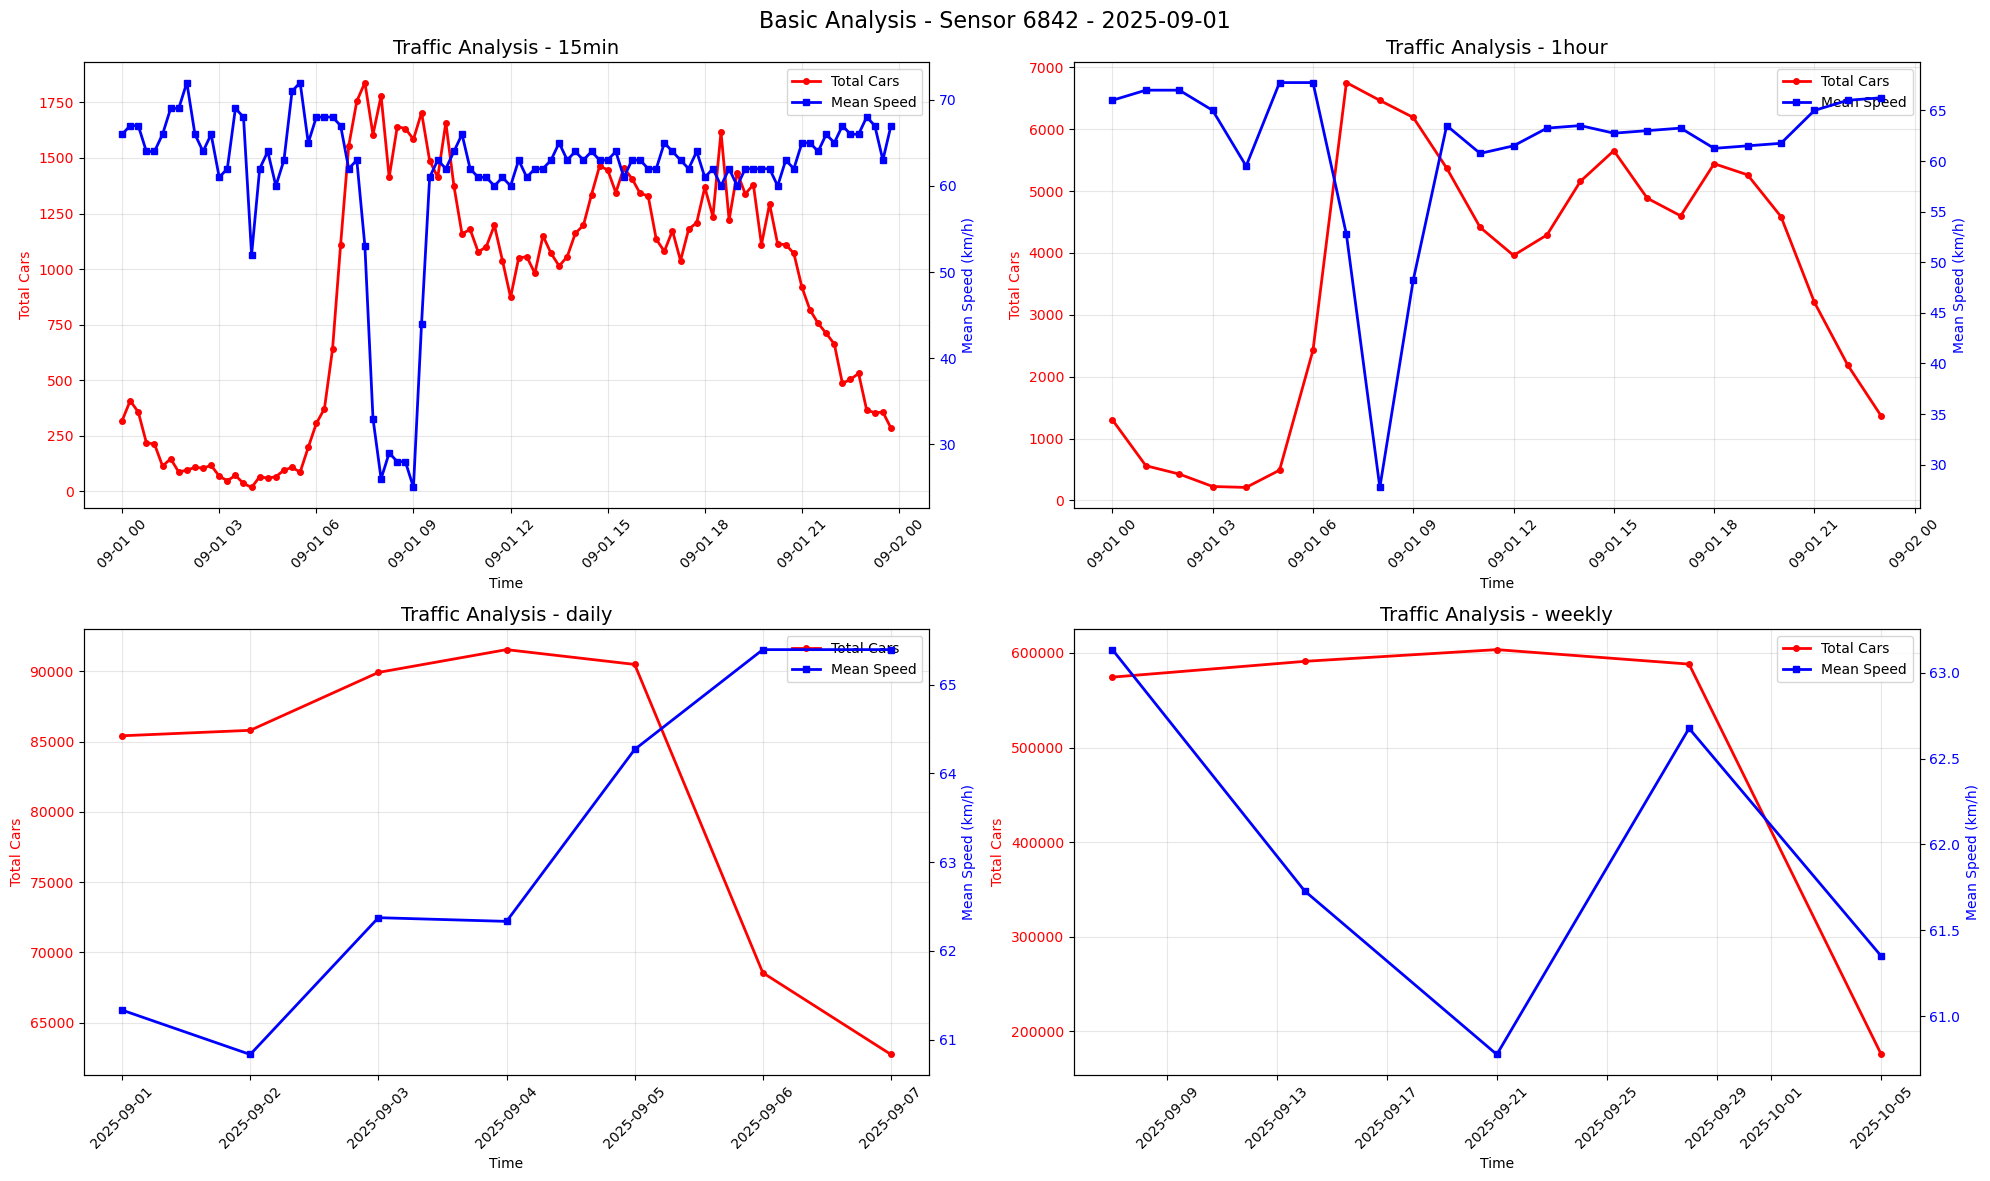

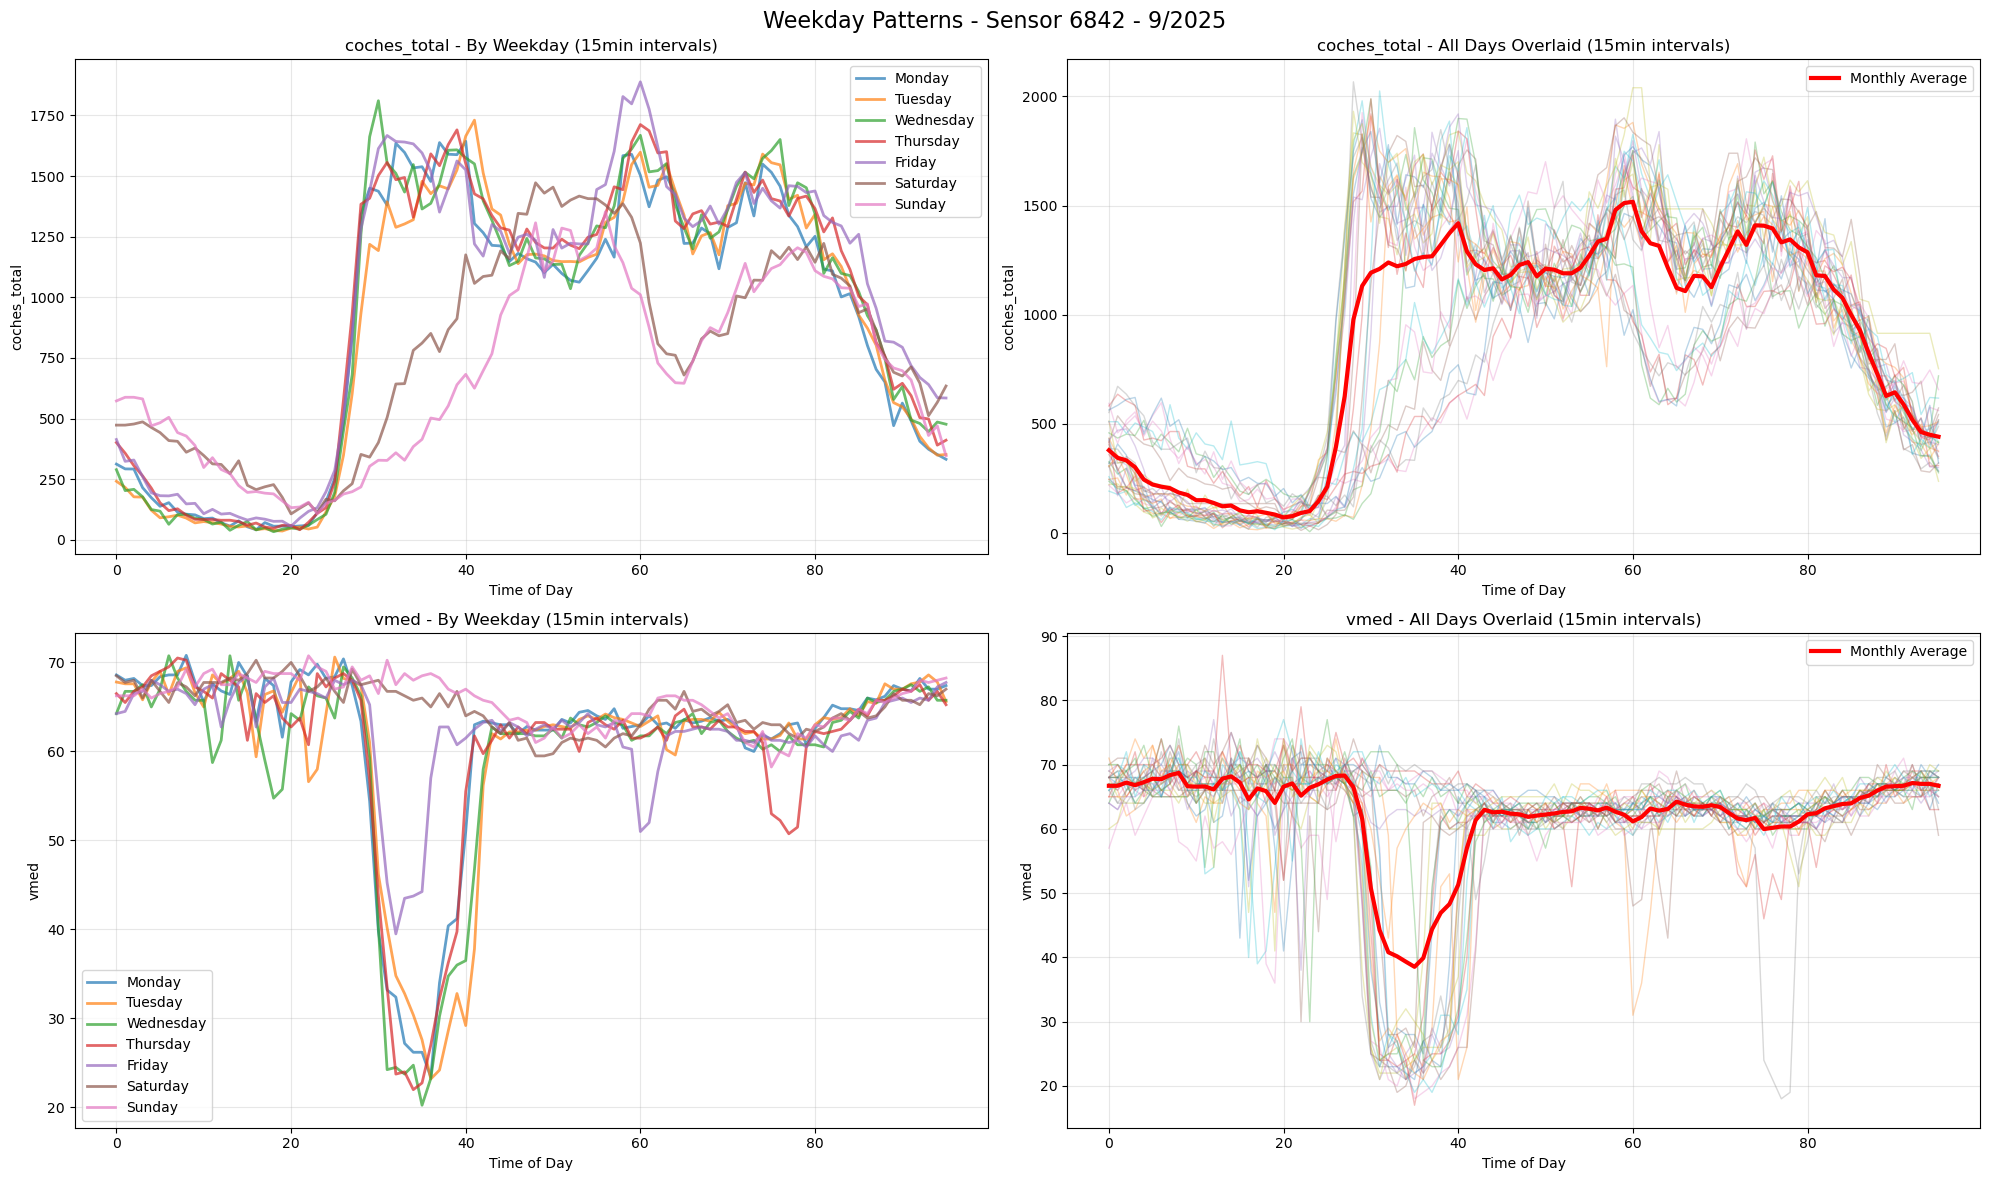

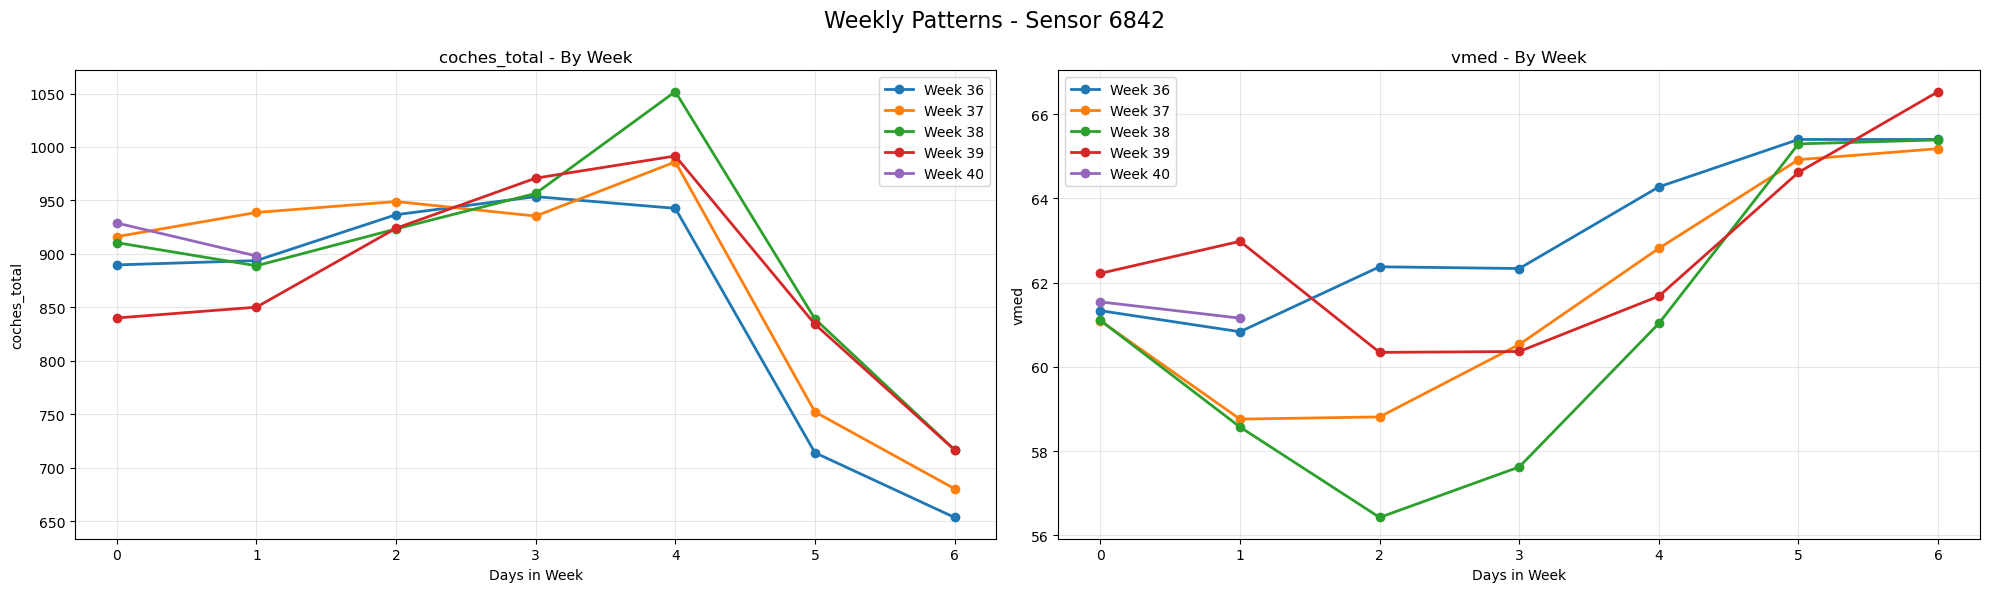

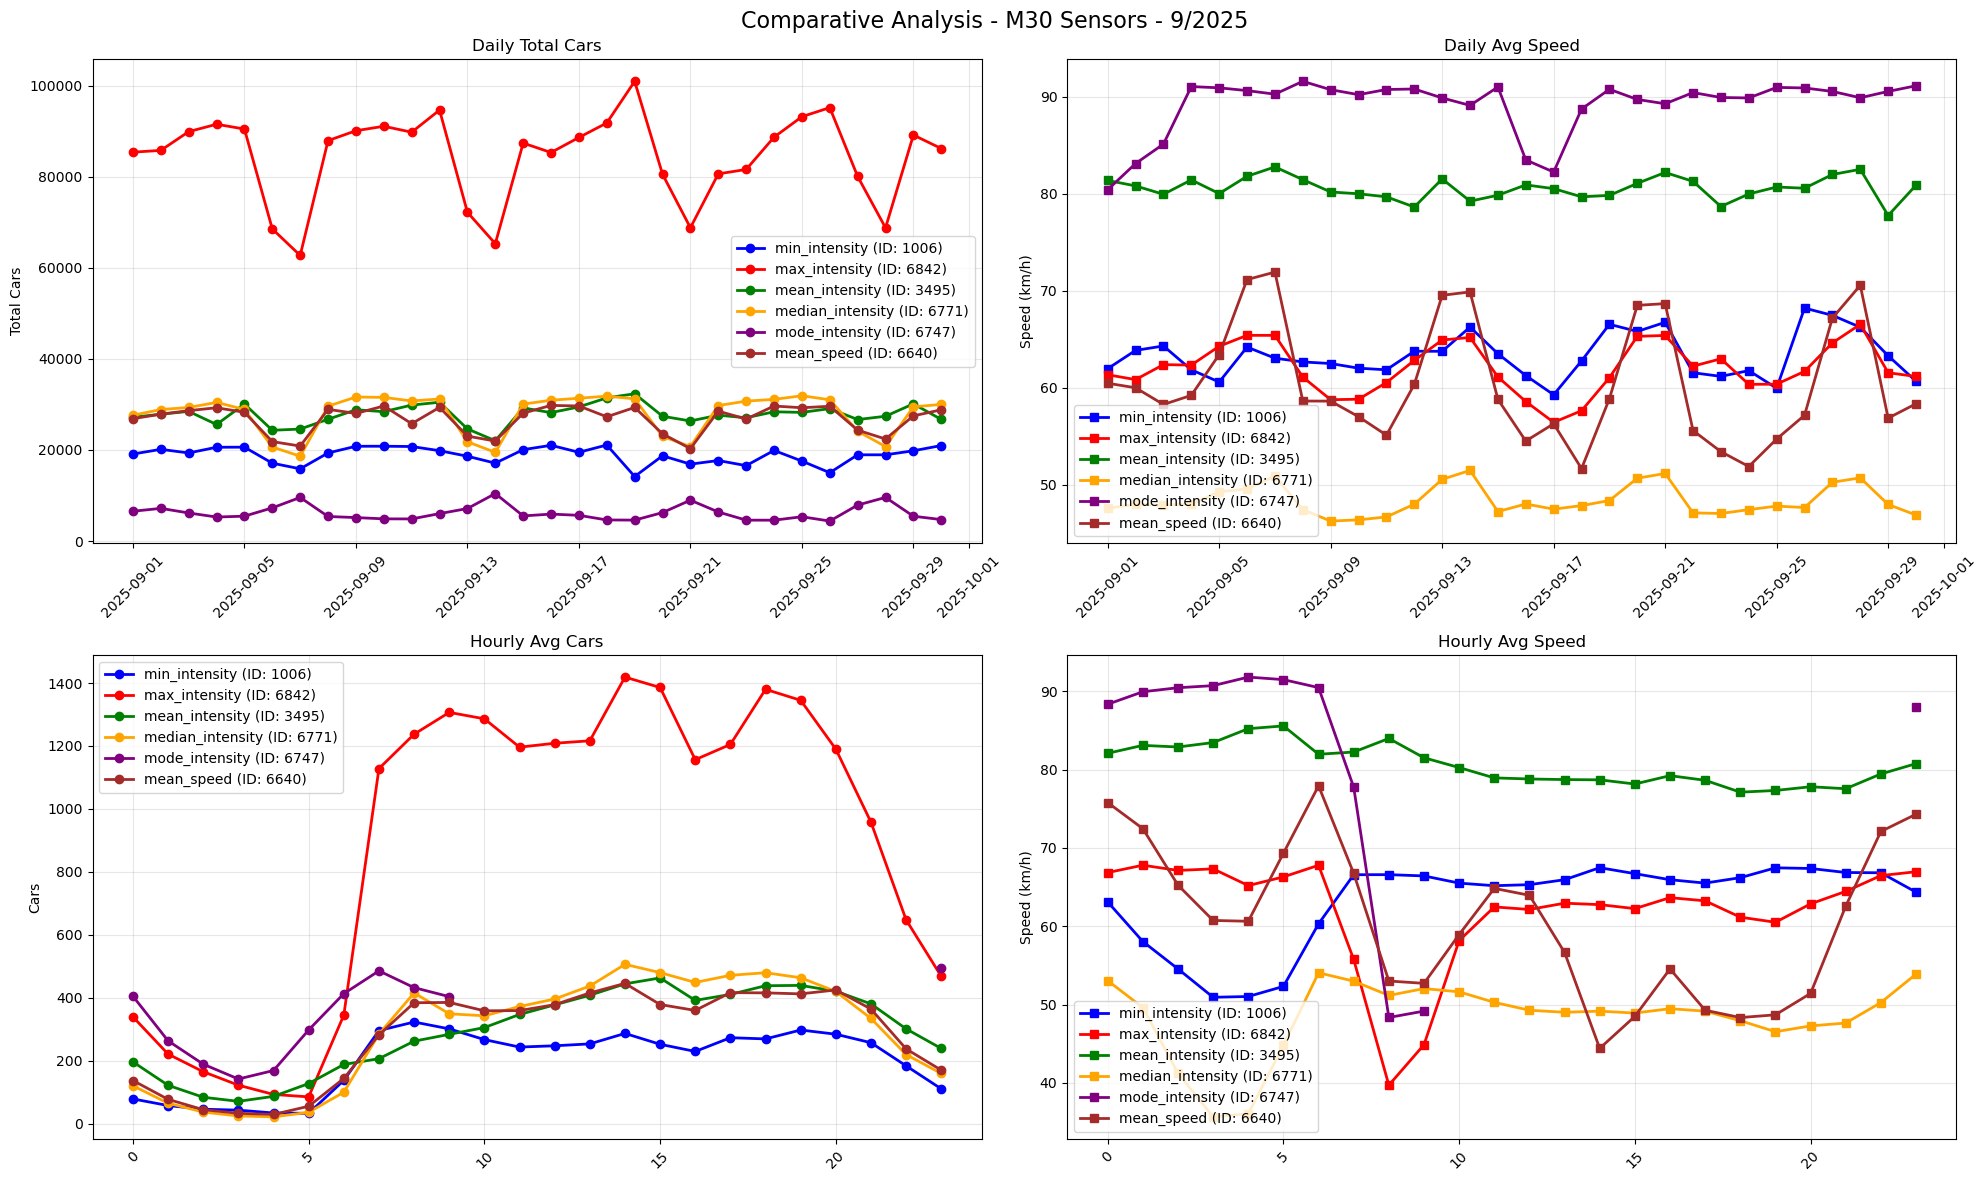

In [103]:
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

def prepare_sensor_data(data, sensor_id):
    """
    Prepare sensor data with time columns for analysis
    """
    sensor_data = data[data['id'] == sensor_id].copy()
    
    if sensor_data.empty:
        return None
        
    # Add time columns for easier filtering
    sensor_data["week"] = sensor_data.index.isocalendar().week
    sensor_data["weekday"] = sensor_data.index.dayofweek
    sensor_data["day"] = sensor_data.index.day
    sensor_data["month"] = sensor_data.index.month
    sensor_data["year"] = sensor_data.index.year
    
    return sensor_data


def filter_monthly_data(sensor_data, date):
    """
    Filter data for entire month based on given date
    """
    target_month = pd.to_datetime(date).month
    target_year = pd.to_datetime(date).year
    
    return sensor_data[
        (sensor_data.index.month == target_month) & 
        (sensor_data.index.year == target_year)
    ]


def plot_weekday_patterns(monthly_data, sensor_id, target_month, target_year):
    """
    Plot traffic patterns by weekday (all Mondays, Tuesdays, etc.)
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle(f'Weekday Patterns - Sensor {sensor_id} - {target_month}/{target_year}', fontsize=16)
    
    weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    
    for stat_idx, stat in enumerate(['coches_total', 'vmed']):
        for weekday in range(7):
            weekday_data = monthly_data[monthly_data['weekday'] == weekday]
            
            if not weekday_data.empty:
                # 15min intervals
                daily_avg_15min = weekday_data.groupby(weekday_data.index.time)[stat].mean()
                
                axes[stat_idx, 0].plot(range(len(daily_avg_15min)), daily_avg_15min, 
                                     label=weekday_names[weekday], alpha=0.7, linewidth=2)
        
        axes[stat_idx, 0].set_title(f'{stat} - By Weekday (15min intervals)')
        axes[stat_idx, 0].set_xlabel('Time of Day')
        axes[stat_idx, 0].set_ylabel(stat)
        axes[stat_idx, 0].legend()
        axes[stat_idx, 0].grid(True, alpha=0.3)
        
        # Overlay all days of month
        unique_days = sorted(monthly_data['day'].unique())
        
        for day in unique_days:
            day_data = monthly_data[monthly_data['day'] == day]
            if not day_data.empty:
                daily_15min = day_data.groupby(day_data.index.time)[stat].mean()
                axes[stat_idx, 1].plot(range(len(daily_15min)), daily_15min, 
                                     alpha=0.3, linewidth=1)
        
        # Monthly average
        all_day_avg = monthly_data.groupby(monthly_data.index.time)[stat].mean()
        axes[stat_idx, 1].plot(range(len(all_day_avg)), all_day_avg, 
                             color='red', linewidth=3, label='Monthly Average')
        
        axes[stat_idx, 1].set_title(f'{stat} - All Days Overlaid (15min intervals)')
        axes[stat_idx, 1].set_xlabel('Time of Day')
        axes[stat_idx, 1].set_ylabel(stat)
        axes[stat_idx, 1].legend()
        axes[stat_idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_weekly_patterns(monthly_data, sensor_id):
    """
    Plot traffic patterns by week
    """
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    fig.suptitle(f'Weekly Patterns - Sensor {sensor_id}', fontsize=16)
    
    unique_weeks = sorted(monthly_data['week'].unique())
    
    for stat_idx, stat in enumerate(['coches_total', 'vmed']):
        for week in unique_weeks:
            week_data = monthly_data[monthly_data['week'] == week]
            if not week_data.empty:
                daily_week = week_data.resample('D')[stat].mean()
                axes[stat_idx].plot(range(len(daily_week)), daily_week, 
                                  marker='o', label=f'Week {week}', linewidth=2)
        
        axes[stat_idx].set_title(f'{stat} - By Week')
        axes[stat_idx].set_xlabel('Days in Week')
        axes[stat_idx].set_ylabel(stat)
        axes[stat_idx].legend()
        axes[stat_idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_basic_analysis(sensor_data, sensor_id, date):
    """
    Basic plotting functionality with 4 different time aggregations
    """
    daily_data = sensor_data[sensor_data.index.date == pd.to_datetime(date).date()]
    weekly_data = sensor_data[sensor_data["week"] == pd.to_datetime(date).isocalendar().week]
    monthly_data = sensor_data[sensor_data.index.month == pd.to_datetime(date).month]
    
    if daily_data.empty:
        print(f"No data for {sensor_id} on {date}")
        return
    
    # Resample data
    data_15min = daily_data
    data_1hour = daily_data.resample('h').agg({
        'intensidad': 'mean', 'vmed': 'mean', 'coches_total': 'sum'
    })
    data_daily = weekly_data.resample('D').agg({
        'intensidad': 'mean', 'vmed': 'mean', 'coches_total': 'sum'
    })
    data_weekly = monthly_data.resample('W').agg({
        'intensidad': 'mean', 'vmed': 'mean', 'coches_total': 'sum'
    })

    # Create datasets list
    datasets = [
        (data_15min, "15min"),
        (data_1hour, "1hour"), 
        (data_daily, "daily"), 
        (data_weekly, "weekly")
    ]
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle(f'Basic Analysis - Sensor {sensor_id} - {date}', fontsize=16)
    
    # Plot each dataset in its own subplot
    for idx, (dataset, period) in enumerate(datasets):
        if dataset.empty:
            continue
            
        row = idx // 2
        col = idx % 2
        
        # Plot coches_total
        axes[row, col].plot(dataset.index, dataset['coches_total'], 
                           color='red', marker='o', linewidth=2, markersize=4, 
                           label='Total Cars')
        
        # Create secondary y-axis for velocity
        ax2 = axes[row, col].twinx()
        ax2.plot(dataset.index, dataset['vmed'], 
                color='blue', marker='s', linewidth=2, markersize=4, 
                label='Mean Speed')
        
        # Configure primary axis (cars)
        axes[row, col].set_title(f'Traffic Analysis - {period}', fontsize=14)
        axes[row, col].set_xlabel('Time')
        axes[row, col].set_ylabel('Total Cars', color='red')
        axes[row, col].tick_params(axis='y', labelcolor='red')
        axes[row, col].tick_params(axis='x', rotation=45)
        axes[row, col].grid(True, alpha=0.3)
        
        # Configure secondary axis (speed)
        ax2.set_ylabel('Mean Speed (km/h)', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        
        # Add legends
        lines1, labels1 = axes[row, col].get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        axes[row, col].legend(lines1 + lines2, labels1 + labels2, loc='upper right')
    
    plt.tight_layout()
    plt.show()


def compare_multiple_sensors(data, sensor_dict, sensor_type, date=None):
    """
    Comparative analysis of multiple sensors
    """
    target_month = pd.to_datetime(date).month if date else data.index[0].month
    target_year = pd.to_datetime(date).year if date else data.index[0].year
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle(f'Comparative Analysis - {sensor_type} Sensors - {target_month}/{target_year}', fontsize=16)
    
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for idx, (description, sensor_id) in enumerate(sensor_dict.items()):
        if idx >= len(colors):
            break
            
        sensor_data = data[data['id'] == sensor_id]
        monthly_data = sensor_data[
            (sensor_data.index.month == target_month) & 
            (sensor_data.index.year == target_year)
        ]
        
        if monthly_data.empty:
            continue
            
        # Daily averages
        daily_avg = monthly_data.resample('D').agg({
            'coches_total': 'sum', 'vmed': 'mean'
        })
        
        # Hourly patterns
        hourly_avg = monthly_data.resample('h').agg({
            'coches_total': 'mean', 'vmed': 'mean'
        }).groupby(monthly_data.resample('h').agg({'coches_total': 'mean'}).index.hour).mean()
        
        color = colors[idx % len(colors)]
        
        # Plot comparisons
        axes[0, 0].plot(daily_avg.index, daily_avg['coches_total'], 
                       color=color, marker='o', label=f'{description} (ID: {sensor_id})', linewidth=2)
        axes[0, 1].plot(daily_avg.index, daily_avg['vmed'], 
                       color=color, marker='s', label=f'{description} (ID: {sensor_id})', linewidth=2)
        axes[1, 0].plot(hourly_avg.index, hourly_avg['coches_total'], 
                       color=color, marker='o', label=f'{description} (ID: {sensor_id})', linewidth=2)
        axes[1, 1].plot(hourly_avg.index, hourly_avg['vmed'], 
                       color=color, marker='s', label=f'{description} (ID: {sensor_id})', linewidth=2)
    
    # Configure plots
    titles = ['Daily Total Cars', 'Daily Avg Speed', 'Hourly Avg Cars', 'Hourly Avg Speed']
    ylabels = ['Total Cars', 'Speed (km/h)', 'Cars', 'Speed (km/h)']
    
    for i in range(2):
        for j in range(2):
            idx = i * 2 + j
            axes[i, j].set_title(titles[idx])
            axes[i, j].set_ylabel(ylabels[idx])
            axes[i, j].legend()
            axes[i, j].grid(True, alpha=0.3)
            axes[i, j].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()


def plot_sensor_traffic(data, sensor_id, sensor_type, date=None, analysis_type="basic"):
    """
    Main function - coordinates all analysis types
    """
    # Prepare data
    sensor_data = prepare_sensor_data(data, sensor_id)
    
    if sensor_data is None:
        print(f"No data for {sensor_id}")
        return
    
    # Set default date
    if date is None:
        date = sensor_data.index.date[0]
    
    # Route to appropriate analysis
    if analysis_type == "basic":
        plot_basic_analysis(sensor_data, sensor_id, date)
        
    elif analysis_type == "monthly_patterns":
        monthly_data = filter_monthly_data(sensor_data, date)
        target_month = pd.to_datetime(date).month
        target_year = pd.to_datetime(date).year
        
        # Generate all pattern plots
        plot_weekday_patterns(monthly_data, sensor_id, target_month, target_year)
        plot_weekly_patterns(monthly_data, sensor_id)


# Usage:
plot_sensor_traffic(m30_data, m30_sensors['max_intensity'], "M30", analysis_type="basic")
plot_sensor_traffic(m30_data, m30_sensors['max_intensity'], "M30", analysis_type="monthly_patterns")
compare_multiple_sensors(m30_data, m30_sensors, "M30")

### Descripción de las gráficas

#### Plot 1: Basic Analysis
Se observa claramente una "hora pico" entre las 7:00 y las 9:00 horas de la mañana, donde el número total de coches aumenta significativamente y la velocidad media disminuye. Además, durante los fines de semana, el número total de coches disminuye, mientras que la velocidad media aumenta.
En el análisis semanal, se puede apreciar que el número total de coches se mantiene estable, aunque la velocidad media desciende ligeramente durante la tercera semana de septiembre. En la última semana de septiembre, ambos valores (número de coches y velocidad media) disminuyen, lo que probablemente se deba a que no se trata de una semana completa, sino solo de los dos últimos días del mes.

#### Plot 2: Weekday patterns
El análisis de los patrones por día de la semana muestra que los fines de semana hay menos coches en circulación en comparación con los días laborables. También se observa que el pico máximo de coches durante el día se alcanza un poco más tarde que durante la semana.
Entre las 6:00 y las 10:00 horas de la mañana, la velocidad media disminuye y el número de coches aumenta (el intervalo de tiempo 24-40, que corresponde a 15 minutos cada uno, equivale a las 6:00 de la mañana).

#### Plot 3: Weekly patterns
Nuevamente, se confirma que durante los fines de semana (sábado y domingo) hay menos coches en la calle y estos presentan una velocidad media más alta que el resto de la semana. En la tercera semana del mes (semana 38), se observa un pico muy alto el viernes, tanto en el número de coches como en la velocidad media. Esto podría deberse a la Vuelta Ciclista a España y la apertura de los cortes del tráfico en la C30/M30.

#### Plot 4: Comparative analysis
La comparación de los sensores más representativos muestra un patrón que se repite a lo largo del mes. Los días 16 y 17 de septiembre presentan una caída en la intensidad máxima y en la velocidad media. Según una búsqueda en internet, esto podría deberse a la celebración de la Vuelta Ciclista a España durante ese mes y que provocó cortes de tráfico en la C30/M30.


## 3. Agrupación por Distritos

Se realizó un análisis específico sobre el distrito céntrico, evaluando sus patrones de tráfico. El distrito centro destacó por una intensidad elevada y una dinámica distinta respecto a áreas periféricas, lo que se aprecia en los resultados gráficos.
Se elaboró un mapa de los distritos de Madrid, donde se visualizan todos los sensores y la mediana semanal de vehículos para septiembre, empleando matplotlib para resolver la visualización geográfica ante el fallo de ArcPy. La cartografía muestra claramente la distribución y el peso de cada sensor.
Se intentó generar un mapa de calor mediante Kernel Density Estimation (KDE), pero la implementación no logró producir resultados satisfactorios. Se identificaron dificultades técnicas y de ajuste de parámetros como los principales obstáculos para lograr una visualización adecuada.

In [10]:
import requests

url_distritos = 'https://datos.madrid.es/egob/catalogo/300497-11326516-distritos-municipales-madrid.csv'
url_ubicacion_sensores = 'https://datos.madrid.es/egob/catalogo/202468-269-intensidad-trafico.csv'

response = requests.get(url_distritos)
if response.status_code == 200:
    with open('300497-11326516-distritos-municipales-madrid.csv', 'wb') as f:
        f.write(response.content)
    print("Download complete!")
else:
    print("Download failed. Status code:", response.status_code)

response = requests.get(url_ubicacion_sensores)
if response.status_code == 200:
    with open('202468-269-intensidad-trafico.csv', 'wb') as f:
        f.write(response.content)
    print("Download complete!")
else:
    print("Download failed. Status code:", response.status_code)

Download complete!
Download complete!


### Análisis exploratorio

In [122]:
# load data into pandas dataframe
import pandas as pd
import numpy as np

distr_mad = pd.read_csv('/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/300497-11326516-distritos-municipales-madrid.csv', sep = ',')
ub_sens = pd.read_csv('/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/202468-269-intensidad-trafico.csv', sep=';', encoding="latin-1") # for spanish characters


In [26]:
## merge datasets to get sensor locations with district names
merged_data = pd.merge(ub_sens, distr_mad, left_on='distrito', right_on='COD_DIS', how='left')
merged_data.head()

,tipo_elem,distrito,id,cod_cent,nombre,utm_x,utm_y,longitud,latitud,Shape_Leng,Shape_Area,COD_DIS,COD_DIS_TX,NOMBRE,DISTRI_MAY,DISTRI_MT,FCH_ALTA,FCH_BAJA,OBSERVACIONES,ACUERDO
0,URB,1.0,4245,15005,BARQUILLO N-S(INFANTAS-ALCALA),440986.674917,4.474580e+06,-3.695624,40.419754,"10304,0823462","5228245,50873",1.0,1.0,Centro,CENTRO,CENTRO,NaN,NaN,NaN,NaN
1,URB,2.0,4698,90019,RONDA DE SEGOVIA O-E(GIL IMON-PUERTA TOLEDO),439460.951529,4.473202e+06,-3.713476,40.407233,"12806,7652871","6462175,91405",2.0,2.0,Arganzuela,ARGANZUELA,ARGANZUELA,NaN,NaN,NaN,NaN
2,URB,8.0,9913,93030,Valle de Mena O-E (Isaac Rabin-Juan Andres),438609.907113,4.480418e+06,-3.724203,40.472174,"94480,9093606","237838267,089",8.0,8.0,Fuencarral - El Pardo,FUENCARRAL - EL PARDO,FUENCARRAL - EL PARDO,NaN,NaN,NaN,NaN
3,URB,8.0,6547,73402,(TÁCTICO) CAMINO TIRO A PICHON,436107.633352,4.482265e+06,-3.753905,40.488627,"94480,9093606","237838267,089",8.0,8.0,Fuencarral - El Pardo,FUENCARRAL - EL PARDO,FUENCARRAL - EL PARDO,NaN,NaN,NaN,NaN
4,URB,11.0,5292,85400,(TACTICO) BALEARES S-N,439441.229023,4.472016e+06,-3.713596,40.396551,"18083,304616","14048315,8528",11.0,11.0,Carabanchel,CARABANCHEL,CARABANCHEL,NaN,NaN,NaN,NaN


In [30]:
# merge merged data with data and reformat merged data into long format and merge with traffic data column intensidad and coches total
merged_full = pd.merge(data.reset_index(), merged_data, on='id', how='left')

In [77]:
merged_long = pd.melt(merged_full, id_vars=['fecha', 'id', 'distrito', 'COD_DIS', 'NOMBRE','utm_x', 'utm_y', 'longitud','latitud'], 
                      value_vars=['intensidad', 'coches_total'], 
                      var_name='measurement_type', value_name='value')
merged_long.head()

,fecha,id,distrito,COD_DIS,NOMBRE,utm_x,utm_y,longitud,latitud,measurement_type,value
0,2025-09-01 00:00:00,1006,10.0,10.0,Latina,437526.63849,4.473735e+06,-3.736324,40.411894,intensidad,660.0
1,2025-09-01 00:15:00,1006,10.0,10.0,Latina,437526.63849,4.473735e+06,-3.736324,40.411894,intensidad,324.0
2,2025-09-01 00:30:00,1006,10.0,10.0,Latina,437526.63849,4.473735e+06,-3.736324,40.411894,intensidad,228.0
3,2025-09-01 00:45:00,1006,10.0,10.0,Latina,437526.63849,4.473735e+06,-3.736324,40.411894,intensidad,96.0
4,2025-09-01 01:00:00,1006,10.0,10.0,Latina,437526.63849,4.473735e+06,-3.736324,40.411894,intensidad,264.0


### Gráficas por distrito Centro


 Relevant statistic for sensor type URB with aggregation period: None
Sensor id with minimum intensity 3478.0
Sensor id with maximum intensity 7138.0
Sensor id closest to mean intensidad: 4261.0 (value: 375.4)
Sensor id closest to median intensidad: 3620.0 (value: 399.7)
Sensor id closest to mode intensidad: 4392.0 (value: 378.6)


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_52250/2853084817.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m30_data_district["fecha"] = pd.to_datetime(m30_data_district["fecha"])


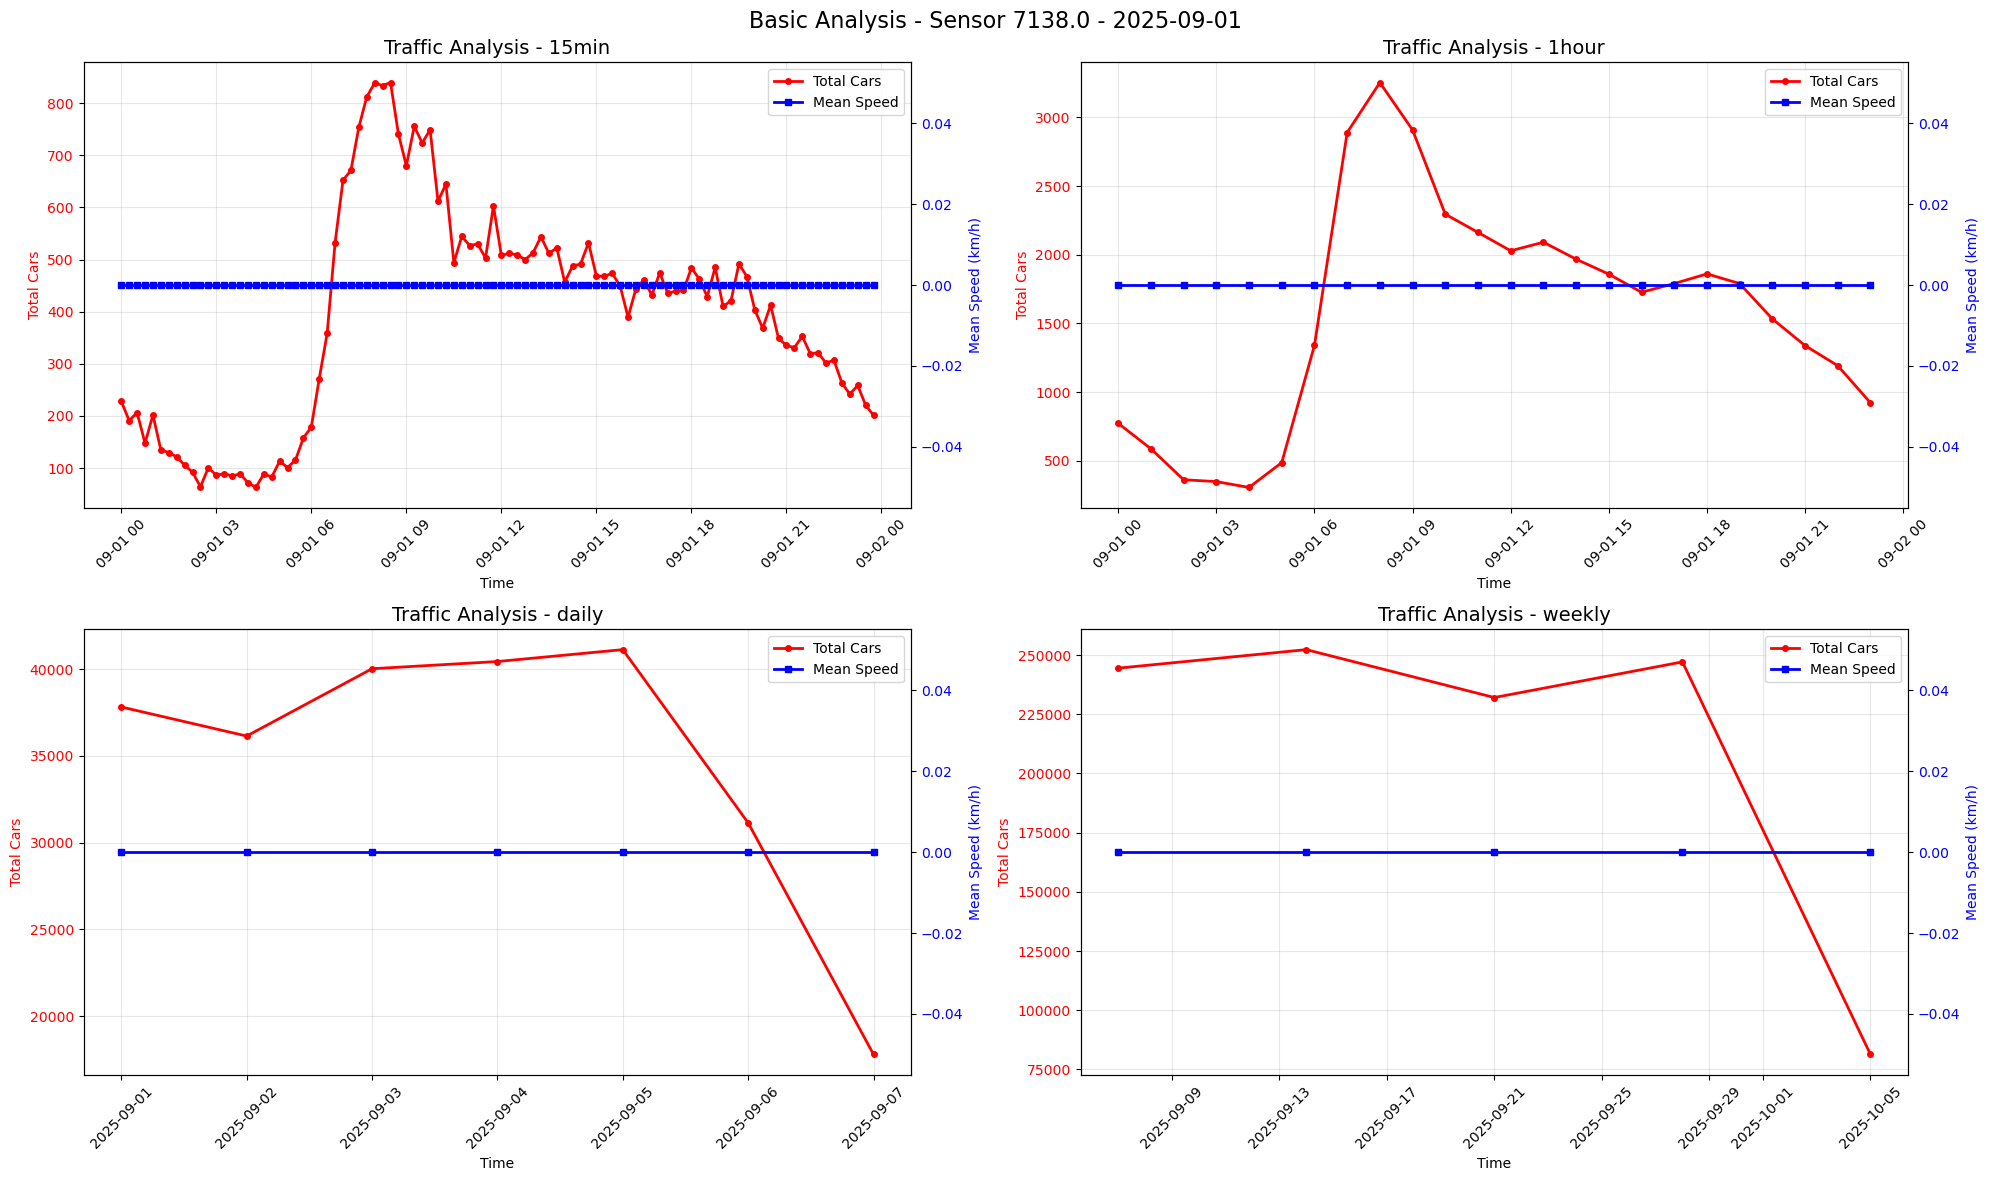

In [121]:
df = merged_full.rename(columns={'tipo_elem_x': 'tipo_elem'})
df = df.where(df['NOMBRE'] == 'Centro')
#df.head()


m30_sensors_district, m30_data_district = get_relevant_sensors(df, "URB", aggregation_period = None)
m30_data_district["fecha"] = pd.to_datetime(m30_data_district["fecha"])
m30_data_district = m30_data_district.set_index("fecha")
plot_sensor_traffic(m30_data_district, m30_sensors_district['max_intensity'], "URB", analysis_type="basic")

### Descripción del plot – Distrito Centro (sensor urbano con intensidad máxima)

#### Plot 1: Basic Analysis – 15 minutos  
En el análisis de 15 minutos se observa una subida muy fuerte del número de coches entre las 7 y las 9 de la mañana, lo que refleja claramente la hora punta en el distrito Centro. Antes y después de ese periodo la intensidad es mucho menor.

#### Plot 2: Basic Analysis – 1 hora  
A escala horaria se repite el mismo patrón: el pico máximo de tráfico ocurre por la mañana y desciende de forma progresiva durante el resto del día.

#### Plot 3: Basic Analysis – diario  
A lo largo de la semana del 1 al 5 de septiembre el volumen de tráfico se mantiene alto, con un máximo el día 5. El fin de semana (6 y 7 de septiembre) muestra una caída clara en la intensidad, algo habitual en la zona Centro.

#### Plot 4: Basic Analysis – semanal  
Las semanas completas presentan valores elevados de tráfico, mientras que la última semana del mes muestra valores mucho más bajos porque incluye solo el fin de semana, cuando la actividad en el distrito Centro disminuye significativamente.


### Aggregación a estadisticas semanales

In [78]:
# calculate monthly statistics for each sensor id in each district for each measurement type
#merged_long["fecha"] = pd.to_datetime(merged_long["fecha"])
merged_long = merged_long.set_index("fecha")
monthly_stats = merged_long.groupby(['distrito', 'NOMBRE', 'id', 'measurement_type', 'longitud', 'latitud']).resample('W').agg({
    'value': ['mean']
}).reset_index()

In [79]:
# remove multiindex columns
monthly_stats.columns = ['distrito', 'NOMBRE', 'id', 'measurement_type', 'longitud', 'latitud', 'fecha', 'mean_value']
monthly_stats.head()

,distrito,NOMBRE,id,measurement_type,longitud,latitud,fecha,mean_value
0,1.0,Centro,1043,coches_total,-3.720762,40.418333,2025-09-07,169.150298
1,1.0,Centro,1043,coches_total,-3.720762,40.418333,2025-09-14,164.093750
2,1.0,Centro,1043,coches_total,-3.720762,40.418333,2025-09-21,173.463064
3,1.0,Centro,1043,coches_total,-3.720762,40.418333,2025-09-28,170.754747
4,1.0,Centro,1043,coches_total,-3.720762,40.418333,2025-10-05,163.041667


In [80]:
# export as csv
monthly_stats.to_csv('/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/merged_monthly_stats.csv', index=False)  

In [81]:
# export monthly stats as geopackage with utm coordinates
import geopandas as gpd
from shapely.geometry import Point

# create geometry column
gdf = gpd.GeoDataFrame(
    monthly_stats, geometry=gpd.points_from_xy(monthly_stats.longitud, monthly_stats.latitud), crs="EPSG:4326"
)
# export as geopackage

gdf.to_file('/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/monthly_sensor_stats.gpkg', driver='GPKG')


### Análisis por distrito

Available weeks in the dataset:
['2025-09-07' '2025-09-14' '2025-09-21' '2025-09-28' '2025-10-05']


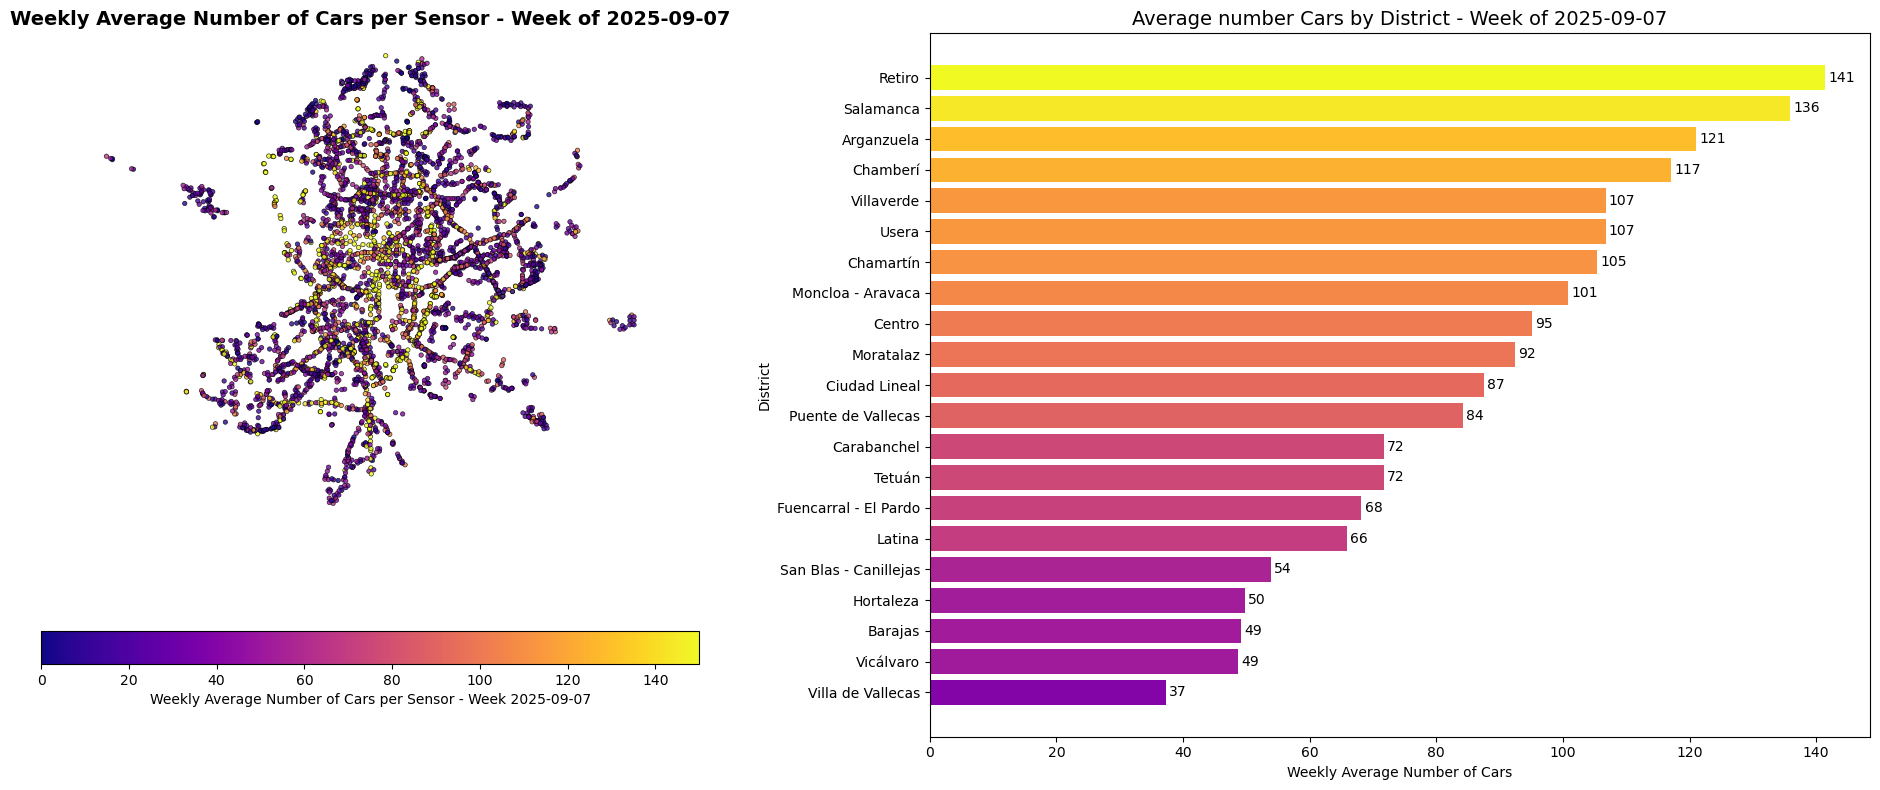


Total number of Cars per district for Week of 2025-09-07:
Ciudad Lineal            : 35944, 411 sensors
Fuencarral - El Pardo    : 35183, 516 sensors
Chamartín                : 34896, 331 sensors
Moncloa - Aravaca        : 28948, 287 sensors
Arganzuela               : 28801, 238 sensors
Salamanca                : 27575, 203 sensors
Carabanchel              : 25468, 355 sensors
Retiro                   : 21358, 151 sensors
Hortaleza                : 16775, 337 sensors
Puente de Vallecas       : 16493, 196 sensors
Tetuán                   : 16204, 226 sensors
Latina                   : 16080, 244 sensors
Usera                    : 16011, 150 sensors
Chamberí                 : 15578, 133 sensors
San Blas - Canillejas    : 15460, 287 sensors
Villaverde               : 13663, 128 sensors
Centro                   : 13599, 143 sensors
Moratalaz                : 10815, 117 sensors
Villa de Vallecas        : 2763, 74 sensors
Vicálvaro                : 2629, 54 sensors
Barajas                  

In [ ]:
# load geopackage with weekly aggregated sensor statistics and filter for specific week
gdf_stats = gpd.read_file('/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/monthly_sensor_stats.gpkg')
import matplotlib.pyplot as plt
import pandas as pd

# Filter for coches_total data
coches_data = gdf_stats[gdf_stats['measurement_type'] == 'coches_total']

# Check available weeks
print("Available weeks in the dataset:")
print(coches_data['fecha'].dt.strftime('%Y-%m-%d').unique())

# Select a specific week (you can change this date)
selected_week = '2025-09-07'  # Change this to your desired week
week_data = coches_data[coches_data['fecha'] == selected_week]

if week_data.empty:
    print(f"No data found for week {selected_week}")
    print("Available weeks:")
    for date in sorted(coches_data['fecha'].unique()):
        print(f"  - {date.strftime('%Y-%m-%d')}")
else:
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Map of sensor locations for selected week
    week_data.plot(column='mean_value', 
                   ax=ax1,
                   legend=True,
                   cmap='plasma',  # Color scheme
                   markersize=10,
                   alpha=0.8,
                   vmin=0,  # Set minimum color value
                   vmax=150,  # Set maximum color value to reasonable limit
                   edgecolors='black',
                   linewidth=0.5,
                   legend_kwds={'label': f"Weekly Average Number of Cars per Sensor - Week {selected_week}",
                              'orientation': "horizontal",
                              'shrink': 0.7})
    ax1.set_title(f'Weekly Average Number of Cars per Sensor - Week of {selected_week}', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Plot 2: District-wise aggregation for selected week
    district_stats = week_data.groupby('NOMBRE')['mean_value'].agg(['sum', 'count', 'mean']).reset_index()
    district_stats.columns = ['NOMBRE', 'sum_coches_total', 'sensor_count', 'mean_coches_total']
    district_stats = district_stats.sort_values('mean_coches_total', ascending=True)

    # Create horizontal bar plot
    bars = ax2.barh(district_stats['NOMBRE'], district_stats['mean_coches_total'], 
                    color=plt.cm.plasma(district_stats['mean_coches_total'] / district_stats['mean_coches_total'].max()))
    ax2.set_title(f'Average number Cars by District - Week of {selected_week}', fontsize=14)
    ax2.set_xlabel('Weekly Average Number of Cars')
    ax2.set_ylabel('District')
    
    # Add value labels on bars
    for bar, value in zip(bars, district_stats['mean_coches_total']):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2.,
                 f'{value:.0f}', ha='left', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for the selected week
    print(f"\nTotal number of Cars per district for Week of {selected_week}:")
    print("="*60)
    for _, row in district_stats.sort_values('sum_coches_total', ascending=False).iterrows():
        print(f"{row['NOMBRE']:<25}: {row['sum_coches_total']:.0f}, {row['sensor_count']} sensors")

### Descripción del plot – Media semanal de coches por sensor y por distrito

#### Plot 1: Media semanal de coches por sensor (mapa)
El mapa muestra la distribución espacial de el número de coches media de tráfico registrada por cada sensor durante la semana seleccionada. Se observa una concentración más alta de tráfico en las zonas centrales y en las vías principales, donde aparecen más puntos en tonos amarillos y naranjas (indicando valores más altos). En cambio, en los barrios periféricos predominan valores más bajos, representados en tonos violetas.

#### Plot 2: Media semanal de coches por distrito (barras)
El gráfico de barras ordena los distritos según su media semanal de coches por sensor. Se calcula como la media semanal de coches por sensor, promediada entre todos los sensores del distrito. Retiro, Salamanca y Arganzuela aparecen como los distritos con mayor intensidad media de tráfico. En contraste, distritos como Vicálvaro, Barajas y Villa de Vallecas registran las medias más bajas de la semana.  
Este contraste refleja la diferencia típica entre los distritos centrales (con más actividad, movilidad y densidad) y los distritos residenciales más alejados del centro urbano.


## 4. Conclusión
El estudio permitió identificar diferencias claras en la concentración de tráfico según el tipo de vía y distrito, así como la utilidad de automatizar el cálculo estadístico y la generación de gráficos. La integración completa en Python resultó útil, aunque la falta de ArcGIS y el fallo en la generación del heatmap señalan oportunidades de mejora para próximas versiones. Se propone la extensión del análisis correlacionando eventos urbanos, condiciones ambientales, o periodos más largos.